# Modelo Lee–Carter rank 2 (tuberculosis)

Este cuaderno replica el flujo de a_01 pero usando un modelo Lee–Carter de rango 2. Mantiene el mismo pipeline, gráficos y métricas; la diferencia es que la descomposición SVD emplea dos componentes en la reconstrucción de log m.

Notas breves:
- Trabajamos sobre log(m), con m = tasa por persona (convertimos de x100k dividiendo por 1e5).
- Usamos SVD y aplicamos restricciones por componente: ∑_x b_x^(j) = 1 y ∑_t k_t^(j) = 0 para j=1,2.
- Se guardan resultados en la carpeta específica del notebook dentro de modelos/outputs/output/.

In [1]:
# Imports y configuración
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rutas
PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PATH = os.path.join(PROJ_ROOT, "data", "processed", "mortalidad")
# Nombre del notebook (fallback si no puede detectarse automáticamente)
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get("NOTEBOOK_BASENAME", "a_02_lee_carter_rank2.ipynb")))[0]
# Carpeta base de outputs y subcarpeta específica del notebook
BASE_OUT = os.path.join(PROJ_ROOT, "modelos", "outputs")
OUT_DIR = os.path.join(BASE_OUT, "output", NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Usando datos desde: {DATA_PATH}")
print(f"Guardando resultados en: {OUT_DIR}")

# Ajustes de display
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (10, 5)

Usando datos desde: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Guardando resultados en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2


In [2]:
# Estilo unificado para gráficos
import sys, os

# Añadir carpeta "src" al PYTHONPATH (robusto a distintas ubicaciones)
for candidate in ("src", "../src", "../../src", "../../../src"):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)

# Recargar el módulo si ya estaba importado (útil al iterar)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap

# Fondo blanco y estilo claro; puedes cambiar n_colors si este notebook usa más líneas/series
apply_matplotlib_style(
    n_colors=7, base_font_size=11,
    seaborn_style="white",
    background="white",
    transparent=False,
)

# Etiquetas para el grupo etario
etiquetas_gr = {
    1:"0–4", 2:"5–9", 3:"10–14", 4:"15–19", 5:"20–24", 6:"25–29",
    7:"30–34", 8:"35–39", 9:"40–44", 10:"45–49", 11:"50–54", 12:"55–59",
    13:"60–64", 14:"65–69", 15:"70–74", 16:"75–79", 17:"≥80", 
}


In [3]:
# Carga de datos: opción 1 (tabla larga)
# Archivo esperado con columnas: ano, gr_et (grupo etario), tasa_x100k, tasa (por persona)
file_long = os.path.join(DATA_PATH, "tasas_mortalidad_gret_per.csv")
df_long = pd.read_csv(file_long)
print(df_long.head())

# Seleccionamos tasa por 100k y convertimos a por persona (m)
df_long = df_long.rename(columns={"ano": "year", "gr_et": "age"})
df_long_m = df_long[["year", "age", "tasa_x100k"]].copy()
df_long_m["m"] = df_long_m["tasa_x100k"] / 1e5
# Protegemos contra ceros para el log
EPS = 1e-12
df_long_m["m"] = df_long_m["m"].clip(lower=EPS)

# Pivot a matriz edad×año
mat = df_long_m.pivot(index="age", columns="year", values="m").sort_index()
mat.head()

    ano  t  gr_et  poblacion  conteo_defunciones  tasa_x100k      tasa
0  1979  1      1    3569687               175.0    4.902391  0.000049
1  1979  1      2    3394629                41.0    1.207790  0.000012
2  1979  1      3    3405357                31.0    0.910330  0.000009
3  1979  1      4    3157420                48.0    1.520229  0.000015
4  1979  1      5    2680815                90.0    3.357188  0.000034


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [4]:
# Carga alternativa: opción 2 (matriz de Lexis)
# Si prefieres usar la matriz directamente, descomenta y ajusta según nombres de filas/columnas
# file_lexis = os.path.join(DATA_PATH, "tasa_mortalidad_lexis.csv")
# df_lex = pd.read_csv(file_lexis)
# # Suponiendo columnas: 'ano', 'gr_et', 'tasa_x100k'
# mat = (df_lex.rename(columns={"ano": "year", "gr_et": "age"})
#               .assign(m=lambda d: (d["tasa_x100k"].clip(lower=0) / 1e5).clip(lower=EPS))
#               .pivot(index="age", columns="year", values="m").sort_index())
# mat.head()

In [5]:
# Implementación Lee–Carter por SVD (rank-2)
# Modelo: log m_{x,t} = a_x + b_x^(1) k_t^(1) + b_x^(2) k_t^(2) + e_{x,t}

# Matriz log m
logm = np.log(mat.values)
ages = mat.index.values
years = mat.columns.values

# a_x: promedio temporal por edad
ax = logm.mean(axis=1, keepdims=True)  # shape (X,1)
# Centrado por a_x
Z = logm - ax

# SVD (rank-2)
U, s, Vt = np.linalg.svd(Z, full_matrices=False)
# Componentes 1 y 2
u1 = U[:, [0]]   # (X,1)
s1 = s[0]
v1 = Vt[[0], :]  # (1,T)

u2 = U[:, [1]] if U.shape[1] > 1 else np.zeros_like(u1)
s2 = s[1] if s.size > 1 else 0.0
v2 = Vt[[1], :] if Vt.shape[0] > 1 else np.zeros_like(v1)

# bx^(1), kt^(1)
b1 = u1 * 1.0
k1 = (s1 * v1).T  # (T,1)
# Restricciones por componente 1: sum_x b_x = 1 y sum_t k_t = 0
b1_sum = b1.sum()
b1 = b1 / b1_sum
k1 = k1 * b1_sum
k1 = k1 - k1.mean()
ax = ax + b1 * k1.mean()  # ajuste para mantener igualdad tras centrar

# bx^(2), kt^(2)
b2 = u2 * 1.0
k2 = (s2 * v2).T  # (T,1)
# Restricciones por componente 2
b2_sum = b2.sum() if np.abs(b2).sum() > 0 else 1.0
b2 = b2 / b2_sum
k2 = k2 * b2_sum
k2 = k2 - k2.mean()
ax = ax + b2 * k2.mean()

# Aplanar y mantener compatibilidad con variables base
ax = ax.ravel()
# Por compatibilidad con celdas posteriores que grafican bx y kt, usamos el componente 1
bx = b1.ravel()
kt = k1.ravel()

# Reconstrucción rank-2
logm_hat = ax[:, None] + np.outer(b1.ravel(), k1.ravel()) + np.outer(b2.ravel(), k2.ravel())
m_hat = np.exp(logm_hat)

# Métricas simples
rmse = np.sqrt(np.mean((np.exp(logm) - m_hat)**2))
mae = np.mean(np.abs(np.exp(logm) - m_hat))
print(f"RMSE (m): {rmse:.6e}  |  MAE (m): {mae:.6e}")


RMSE (m): 2.083607e-05  |  MAE (m): 9.799640e-06


In [6]:
# Utilidad: etiquetas de grupo etario en ejes
# Mapea índices (1..17) a los rangos definidos en `etiquetas_gr`

def age_label(val):
    try:
        return etiquetas_gr[int(val)]
    except Exception:
        try:
            return etiquetas_gr[int(float(val))]
        except Exception:
            return str(val)

def get_age_labels(values):
    return [age_label(v) for v in values]

def set_age_ticks(ax, values, axis='x', rotation=0):
    labels = get_age_labels(values)
    if axis == 'x':
        ax.set_xticks(values)
        ax.set_xticklabels(labels, rotation=45)
    elif axis == 'y':
        ax.set_yticks(values)
        ax.set_yticklabels(labels, rotation=rotation)

## Pronósticos

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_by_age.csv


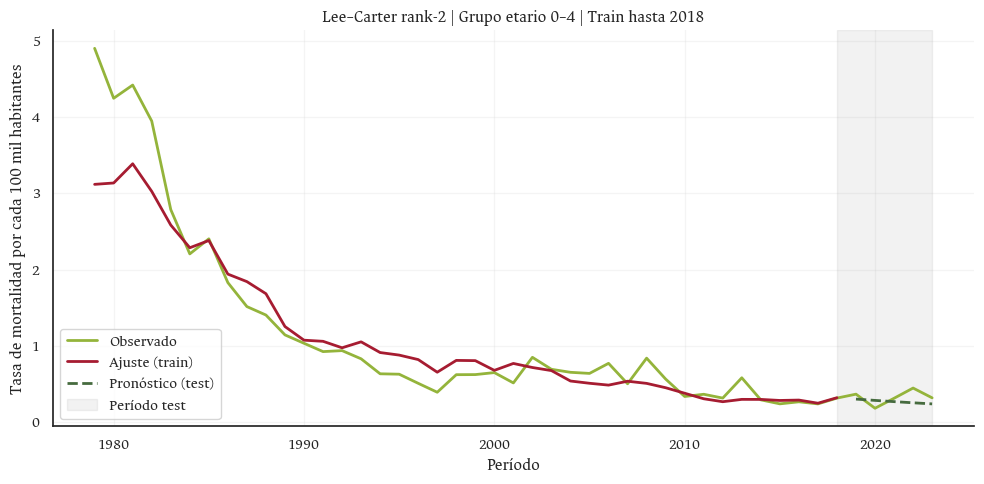

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_rank2_forecast_age1.png


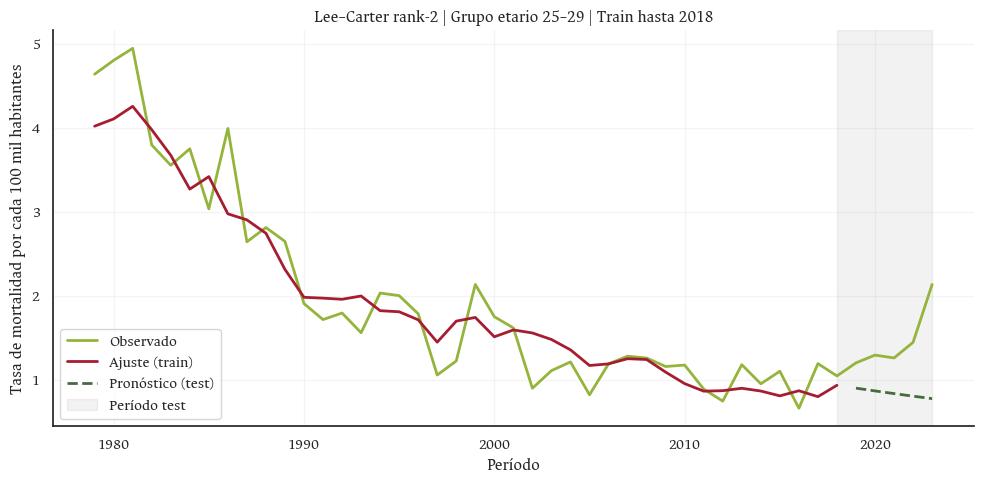

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_rank2_forecast_age6.png


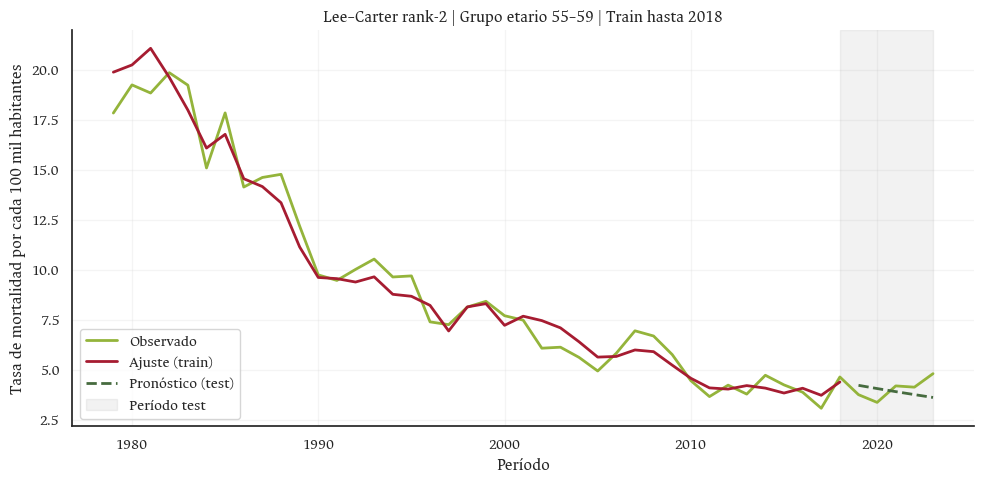

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_rank2_forecast_age12.png


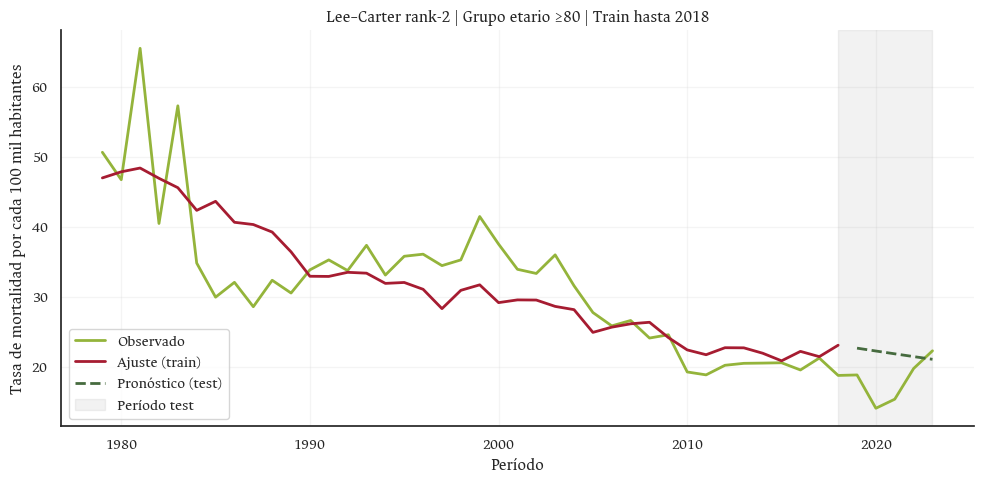

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_rank2_forecast_age17.png


In [7]:
# Pronóstico Lee–Carter (rank-2): split train/test y gráficos por edad
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

# Parámetros de experimento
TEST_LAST = 5  # número de años al final para test/pronóstico
AGES_TO_PLOT = [1, 6, 12, 17]  # grupos etarios a mostrar (ajusta a conveniencia)

# Validación de edades
available_ages = set(ages.tolist())
AGES_TO_PLOT = [a for a in AGES_TO_PLOT if a in available_ages]
if not AGES_TO_PLOT:
    AGES_TO_PLOT = [int(ages[0])]  # fallback

# Partición temporal
all_years = years.astype(int)
TRAIN_END_YEAR = int(all_years.max() - TEST_LAST)
train_mask = mat.columns.astype(int) <= TRAIN_END_YEAR
test_mask = ~train_mask

mat_train = mat.loc[:, train_mask]
mat_test = mat.loc[:, test_mask]

# Ajuste LC rank-2 solo con TRAIN
logm_tr = np.log(np.clip(mat_train.values, EPS, None))
ax_tr = logm_tr.mean(axis=1, keepdims=True)
Z_tr = logm_tr - ax_tr
U_tr, s_tr, Vt_tr = np.linalg.svd(Z_tr, full_matrices=False)

u1_tr = U_tr[:, [0]]
s1_tr = s_tr[0]
v1_tr = Vt_tr[[0], :]

u2_tr = U_tr[:, [1]] if U_tr.shape[1] > 1 else np.zeros_like(u1_tr)
s2_tr = s_tr[1] if s_tr.size > 1 else 0.0
v2_tr = Vt_tr[[1], :] if Vt_tr.shape[0] > 1 else np.zeros_like(v1_tr)

b1_tr = u1_tr * 1.0
k1_tr = (s1_tr * v1_tr).T
b1_tr_sum = b1_tr.sum()
b1_tr = b1_tr / b1_tr_sum
k1_tr = k1_tr * b1_tr_sum
k1_tr = k1_tr - k1_tr.mean()
ax_tr = ax_tr + b1_tr * k1_tr.mean()

b2_tr = u2_tr * 1.0
k2_tr = (s2_tr * v2_tr).T
b2_tr_sum = b2_tr.sum() if np.abs(b2_tr).sum() > 0 else 1.0
b2_tr = b2_tr / b2_tr_sum
k2_tr = k2_tr * b2_tr_sum
k2_tr = k2_tr - k2_tr.mean()
ax_tr = ax_tr + b2_tr * k2_tr.mean()

ax_tr = ax_tr.ravel()
bx_tr = b1_tr.ravel()  # para compatibilidad con algunas tablas
kt_tr = k1_tr.ravel()  # idem
# Guardamos también los componentes 2
bx2_tr = b2_tr.ravel()
kt2_tr = k2_tr.ravel()

years_train = mat_train.columns.astype(int).values
years_test = mat_test.columns.astype(int).values

# Modelo temporal para k_t^(1) y k_t^(2): ARIMA(0,1,0) con tendencia lineal
h = len(years_test)
if h > 0 and len(kt_tr) >= 3:
    model1 = ARIMA(kt_tr, order=(0,1,0), trend='t')
    res1 = model1.fit()
    kt1_fore = np.asarray(res1.forecast(steps=h))
else:
    kt1_fore = np.zeros(h)

if h > 0 and len(kt2_tr) >= 3:
    model2 = ARIMA(kt2_tr, order=(0,1,0), trend='t')
    res2 = model2.fit()
    kt2_fore = np.asarray(res2.forecast(steps=h))
else:
    kt2_fore = np.zeros(h)

# Reconstrucción rank-2
logm_hat_train = ax_tr[:, None] + np.outer(b1_tr.ravel(), k1_tr.ravel()) + np.outer(b2_tr.ravel(), k2_tr.ravel())
logm_hat_test = ax_tr[:, None] + np.outer(b1_tr.ravel(), kt1_fore) + np.outer(b2_tr.ravel(), kt2_fore) if h > 0 else np.empty((len(ax_tr), 0))

m_hat_train = np.exp(logm_hat_train)  # shape: (X, T_train)
m_hat_test = np.exp(logm_hat_test)    # shape: (X, T_test)

# Armar DataFrame largo por edad y año

def build_df_by_age(age_idx):
    age_val = ages[age_idx]
    obs_train = mat_train.iloc[age_idx, :].values * 1e5
    fit_train = m_hat_train[age_idx, :] * 1e5
    obs_test = mat_test.iloc[age_idx, :].values * 1e5 if h > 0 else np.array([])
    fit_test = m_hat_test[age_idx, :] * 1e5 if h > 0 else np.array([])

    df_tr = pd.DataFrame({
        'age': age_val,
        'age_label': age_label(age_val),
        'year': years_train,
        'obs_x100k': obs_train,
        'pred_x100k': fit_train,
        'phase': 'train'
    })
    df_ts = pd.DataFrame({
        'age': age_val,
        'age_label': age_label(age_val),
        'year': years_test,
        'obs_x100k': obs_test,
        'pred_x100k': fit_test,
        'phase': 'test'
    }) if h > 0 else pd.DataFrame(columns=df_tr.columns)
    return pd.concat([df_tr, df_ts], ignore_index=True)

# Construir y guardar series para edades seleccionadas
rows = []
for a in AGES_TO_PLOT:
    idx = int(np.where(ages == a)[0][0])
    rows.append(build_df_by_age(idx))

forecast_df = pd.concat(rows, ignore_index=True)
forecast_df['err_abs'] = np.abs(forecast_df['obs_x100k'] - forecast_df['pred_x100k'])
forecast_df['error_pct'] = np.abs(forecast_df['obs_x100k'] - forecast_df['pred_x100k']) / forecast_df['obs_x100k'] * 100.0
forecast_csv = os.path.join(OUT_DIR, "lee_carter_forecast_by_age.csv")
forecast_df.to_csv(forecast_csv, index=False)
print("Guardado:", forecast_csv)

# Gráficos por edad
import matplotlib.dates as mdates
palette3 = get_palette(3)

for a in AGES_TO_PLOT:
    sub = forecast_df[forecast_df['age'] == a].sort_values('year')
    fig, axp = plt.subplots(figsize=(10,5))

    # Observado (todo)
    axp.plot(sub['year'], sub['obs_x100k'], color=palette3[0], label='Observado', linewidth=2)

    # Ajuste (train)
    tr = sub[sub['phase'] == 'train']
    axp.plot(tr['year'], tr['pred_x100k'], color=palette3[1], label='Ajuste (train)', linewidth=2)

    # Pronóstico (test)
    ts = sub[sub['phase'] == 'test']
    if not ts.empty:
        axp.plot(ts['year'], ts['pred_x100k'], color=palette3[2], linestyle='--', label='Pronóstico (test)', linewidth=2)
        axp.axvspan(TRAIN_END_YEAR + 0.0, sub['year'].max(), color='gray', alpha=0.1, label='Período test')

    label_a = age_label(a)
    axp.set_title(f"Lee–Carter rank-2 | Grupo etario {label_a} | Train hasta {TRAIN_END_YEAR}")
    axp.set_xlabel("Período")
    axp.set_ylabel("Tasa de mortalidad por cada 100 mil habitantes")
    axp.legend()
    axp.grid(alpha=0.2)
    axp.spines['top'].set_visible(False)
    axp.spines['right'].set_visible(False)
    plt.tight_layout()

    out_png = os.path.join(OUT_DIR, f"lee_carter_rank2_forecast_age{a}.png")
    fig.savefig(out_png, dpi=150)
    plt.show()
    print("Figura:", out_png)

# Nota: Puedes cambiar TEST_LAST y AGES_TO_PLOT para otros cortes/períodos.


In [8]:
forecast_df.head()

,age,age_label,year,obs_x100k,pred_x100k,phase,err_abs,error_pct
0,1,0–4,1979,4.902391,3.118452,train,1.783939,36.389163
1,1,0–4,1980,4.247333,3.136340,train,1.110992,26.157413
2,1,0–4,1981,4.420562,3.388362,train,1.032200,23.349971
3,1,0–4,1982,3.948397,3.026352,train,0.922045,23.352379
4,1,0–4,1983,2.787878,2.584887,train,0.202991,7.281199


Bootstrap 50/200...
Bootstrap 100/200...
Bootstrap 150/200...
Bootstrap 200/200...
Guardadas bandas en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2


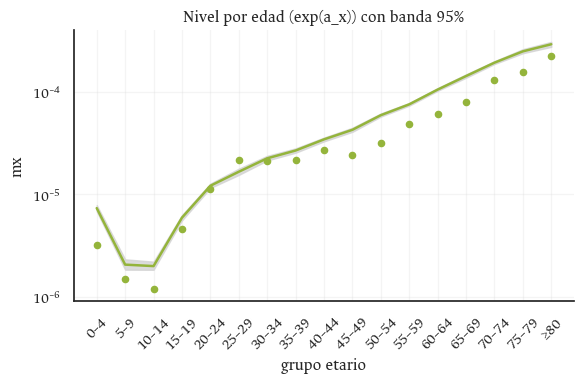

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_ax_bands.png


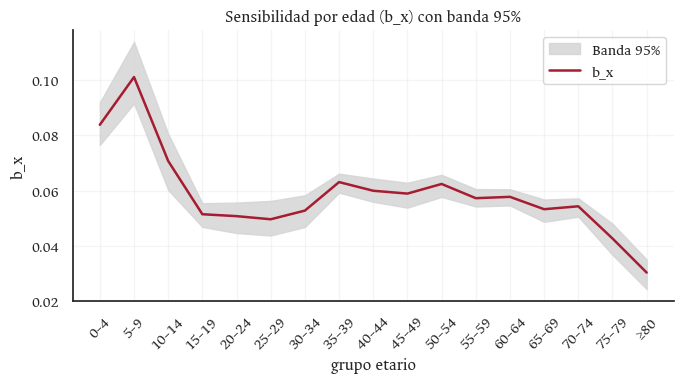

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_bx_bands.png


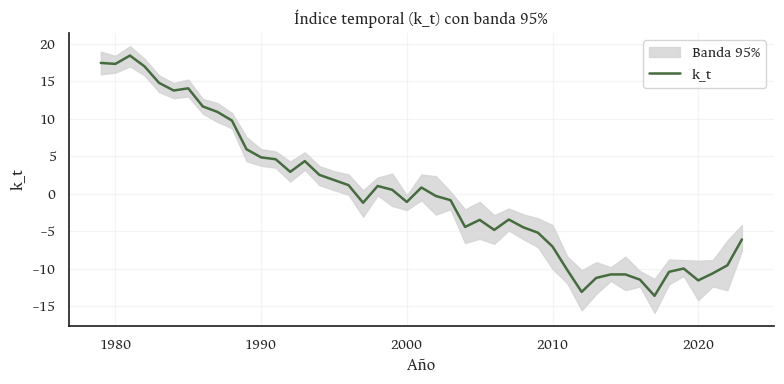

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_kt_bands.png


In [9]:
# Bandas de incertidumbre por bootstrap para parámetros a_x, b_x, k_t
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del bootstrap
B = 200  # número de réplicas (ajústalo si deseas más/menos)
rng = np.random.default_rng(12345)

# Función de ajuste LC con restricciones estándar
def fit_lc_from_logm(logm_arr):
    ax_ = logm_arr.mean(axis=1, keepdims=True)
    Z_ = logm_arr - ax_
    U_, s_, Vt_ = np.linalg.svd(Z_, full_matrices=False)
    u1_ = U_[:, [0]]
    s1_ = s_[0]
    v1_ = Vt_[[0], :]
    bx_ = u1_ * 1.0
    kt_ = (s1_ * v1_).T
    bx_sum_ = bx_.sum()
    bx_ = bx_ / bx_sum_
    kt_ = kt_ * bx_sum_
    kt_ = kt_ - kt_.mean()
    return ax_.ravel(), bx_.ravel(), kt_.ravel()

# Residuales del ajuste actual sobre log m
logm_fit = ax[:, None] + np.outer(bx, kt)
resid = logm - logm_fit

# Wild bootstrap (Rademacher): e* = e * s, con s en {+1, -1}
boot_ax = []
boot_bx = []
boot_kt = []
for b in range(B):
    signs = rng.choice([-1.0, 1.0], size=resid.shape)
    logm_star = logm_fit + resid * signs
    ax_b, bx_b, kt_b = fit_lc_from_logm(logm_star)
    boot_ax.append(ax_b)
    boot_bx.append(bx_b)
    boot_kt.append(kt_b)
    if (b+1) % 50 == 0:
        print(f"Bootstrap {b+1}/{B}...")

boot_ax = np.vstack(boot_ax)
boot_bx = np.vstack(boot_bx)
boot_kt = np.vstack(boot_kt)

# Percentiles punto-a-punto
ax_lo, ax_med, ax_hi = np.percentile(boot_ax, [2.5, 50, 97.5], axis=0)
bx_lo, bx_med, bx_hi = np.percentile(boot_bx, [2.5, 50, 97.5], axis=0)
kt_lo, kt_med, kt_hi = np.percentile(boot_kt, [2.5, 50, 97.5], axis=0)

# Guardar tablas de bandas
bands_dir = OUT_DIR
pd.DataFrame({"age": ages, "ax_lo": ax_lo, "ax_med": ax_med, "ax_hi": ax_hi}).to_csv(os.path.join(bands_dir, "bands_ax.csv"), index=False)
pd.DataFrame({"age": ages, "bx_lo": bx_lo, "bx_med": bx_med, "bx_hi": bx_hi}).to_csv(os.path.join(bands_dir, "bands_bx.csv"), index=False)
pd.DataFrame({"year": years, "kt_lo": kt_lo, "kt_med": kt_med, "kt_hi": kt_hi}).to_csv(os.path.join(bands_dir, "bands_kt.csv"), index=False)
print("Guardadas bandas en:", bands_dir)

# Gráfico estilo adjunto para exp(a_x) ~ nivel mx promedio por edad
palette3 = get_palette(3)
mx_hat = np.exp(ax)
mx_lo = np.exp(ax_lo)
mx_hi = np.exp(ax_hi)

fig, axp = plt.subplots(figsize=(6,4))
axp.fill_between(ages, mx_lo, mx_hi, color="lightgray", alpha=0.8, step=None, label="Banda 95%")
axp.plot(ages, mx_hat, color=palette3[0], linewidth=1.8, label="exp(a_x)")
# Puntos observados (tasa de último año para referencia visual)
last_year = int(years.max())
obs_last = mat[last_year].values  # m por persona
axp.scatter(ages, obs_last, color=palette3[0], s=20)
axp.set_yscale("log")
axp.set_xlabel("grupo etario")
axp.set_ylabel("mx")
set_age_ticks(axp, ages, 'x')
axp.set_title("Nivel por edad (exp(a_x)) con banda 95%")
axp.grid(alpha=0.2)
axp.spines['top'].set_visible(False)
axp.spines['right'].set_visible(False)
plt.tight_layout()
ax_png = os.path.join(OUT_DIR, "lee_carter_ax_bands.png")
fig.savefig(ax_png, dpi=150)
plt.show()
print("Figura:", ax_png)

# Gráfico para b_x con banda
fig, axp2 = plt.subplots(figsize=(7,4))
axp2.fill_between(ages, bx_lo, bx_hi, color="lightgray", alpha=0.8, label="Banda 95%")
axp2.plot(ages, bx, color=palette3[1], linewidth=1.8, label="b_x")
axp2.set_xlabel("grupo etario")
axp2.set_ylabel("b_x")
set_age_ticks(axp2, ages, 'x')
axp2.set_title("Sensibilidad por edad (b_x) con banda 95%")
axp2.grid(alpha=0.2)
axp2.legend()
axp2.spines['top'].set_visible(False)
axp2.spines['right'].set_visible(False)
plt.tight_layout()
bx_png = os.path.join(OUT_DIR, "lee_carter_bx_bands.png")
fig.savefig(bx_png, dpi=150)
plt.show()
print("Figura:", bx_png)

# Gráfico para k_t con banda
fig, axp3 = plt.subplots(figsize=(8,4))
axp3.fill_between(years, kt_lo, kt_hi, color="lightgray", alpha=0.8, label="Banda 95%")
axp3.plot(years, kt, color=palette3[2], linewidth=1.8, label="k_t")
axp3.set_xlabel("Año")
axp3.set_ylabel("k_t")
axp3.set_title("Índice temporal (k_t) con banda 95%")
axp3.grid(alpha=0.2)
axp3.legend()
axp3.spines['top'].set_visible(False)
axp3.spines['right'].set_visible(False)
plt.tight_layout()
kt_png = os.path.join(OUT_DIR, "lee_carter_kt_bands.png")
fig.savefig(kt_png, dpi=150)
plt.show()
print("Figura:", kt_png)

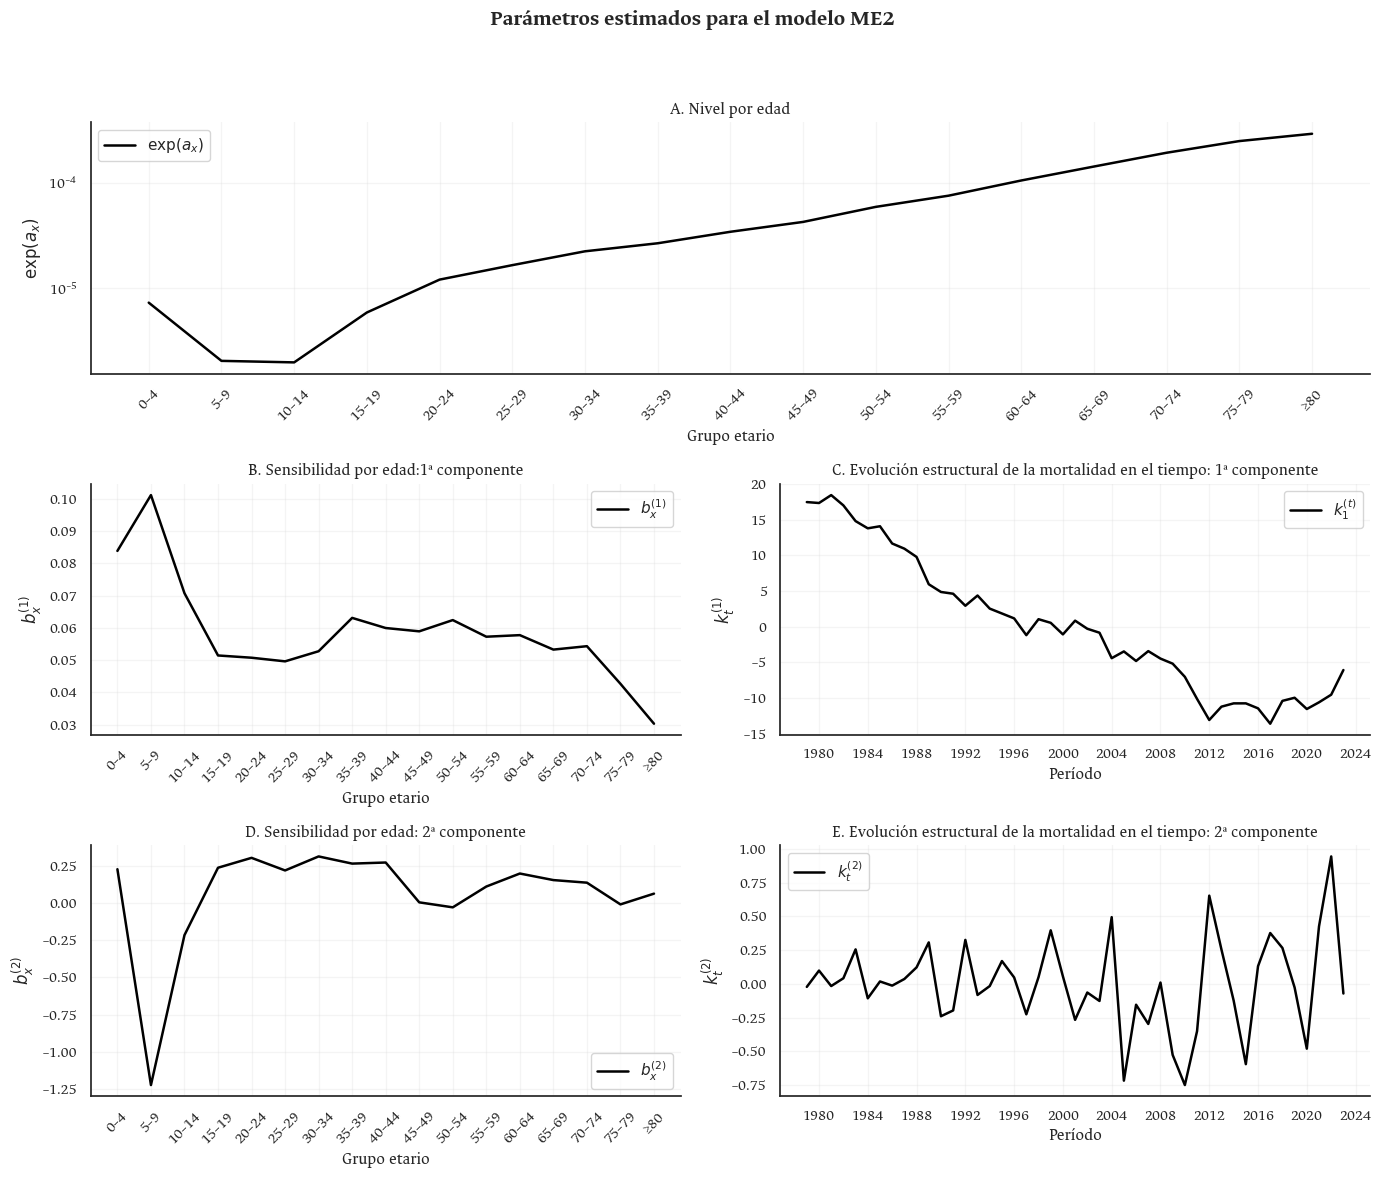

Figura combinada (sin bandas): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_rank2_bands_combined.png


In [20]:
# Bandas rank-2 (bootstrap) ya calculadas arriba; ahora sólo graficamos SIN mostrar bandas.
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# Nota: mantenemos los cálculos previos (boot_ax, boot_b1, boot_b2, boot_k1, boot_k2) ya cargados en memoria
# y las tablas ya guardadas. Aquí sólo cambiamos la disposición y removemos fill_between.

palette3 = get_palette(3)
mx_hat = np.exp(ax)

fig_all = plt.figure(figsize=(14, 12))
# Nueva disposición: fila1 (B, D), fila2 (C, E), fila3 (A ancho completo)
gs = fig_all.add_gridspec(3, 2, height_ratios=[1, 1, 1])

# Panel B: b1_x
ax_b1 = fig_all.add_subplot(gs[1, 0])
# ax_b1.plot(ages, b1, color=palette3[1], linewidth=1.8, label=r"$b_x^{(1)}$")
ax_b1.plot(ages, b1, color="black", linewidth=1.8, label=r"$b_x^{(1)}$")
ax_b1.set_xlabel("Grupo etario")
ax_b1.set_ylabel(r"$b_x^{(1)}$")
set_age_ticks(ax_b1, ages, 'x')
ax_b1.set_title("B. Sensibilidad por edad:1ª componente")
ax_b1.spines['top'].set_visible(False)
ax_b1.spines['right'].set_visible(False)
ax_b1.grid(alpha=0.2)
ax_b1.legend()

# Panel D: k1_t
ax_k1 = fig_all.add_subplot(gs[1, 1])
# ax_k1.plot(years, k1, color=palette3[2], linewidth=1.8, label=r"$k_1^{(t)}$")
ax_k1.plot(years, k1, color="black", linewidth=1.8, label=r"$k_1^{(t)}$")
ax_k1.set_xlabel("Período")
ax_k1.set_ylabel(r"$k_t^{(1)}$")
ax_k1.set_title("C. Evolución estructural de la mortalidad en el tiempo: 1ª componente")
ax_k1.spines['top'].set_visible(False)
ax_k1.spines['right'].set_visible(False)
ax_k1.grid(alpha=0.2)
ax_k1.legend()
ax_k1.xaxis.set_major_locator(plt.MaxNLocator(15))

# Panel C: b2_x
ax_b2 = fig_all.add_subplot(gs[2, 0])
# ax_b2.plot(ages, b2, color=palette3[1], linewidth=1.8, label=r"$b_x^{(2)}$")
ax_b2.plot(ages, b2, color="black", linewidth=1.8, label=r"$b_x^{(2)}$")
ax_b2.set_xlabel("Grupo etario")
ax_b2.set_ylabel(r"$b_x^{(2)}$")
set_age_ticks(ax_b2, ages, 'x')
ax_b2.set_title("D. Sensibilidad por edad: 2ª componente")
ax_b2.spines['top'].set_visible(False)
ax_b2.spines['right'].set_visible(False)
ax_b2.grid(alpha=0.2)
ax_b2.legend()

# Panel E: k2_t
ax_k2 = fig_all.add_subplot(gs[2, 1])
# ax_k2.plot(years, k2, color=palette3[2], linewidth=1.8, label=r"$k_t^{(2)}$")
ax_k2.plot(years, k2, color="black", linewidth=1.8, label=r"$k_t^{(2)}$")
ax_k2.set_xlabel("Período")
ax_k2.set_ylabel(r"$k_t^{(2)}$")
ax_k2.set_title("E. Evolución estructural de la mortalidad en el tiempo: 2ª componente")
ax_k2.spines['top'].set_visible(False)
ax_k2.spines['right'].set_visible(False)
ax_k2.grid(alpha=0.2)
ax_k2.legend()
ax_k2.xaxis.set_major_locator(plt.MaxNLocator(15))

# Panel A: exp(a_x) ocupa toda la tercera fila
ax_ax = fig_all.add_subplot(gs[0, :])
# ax_ax.plot(ages, mx_hat, color=palette3[0], linewidth=1.8, label=r"$\text{exp}(a_x)$")
ax_ax.plot(ages, mx_hat, color="black", linewidth=1.8, label=r"$\text{exp}(a_x)$")
ax_ax.set_yscale("log")
ax_ax.set_xlabel("Grupo etario")
ax_ax.set_ylabel(r"$\text{exp}(a_x)$")
set_age_ticks(ax_ax, ages, 'x')
ax_ax.set_title("A. Nivel por edad")
ax_ax.spines['top'].set_visible(False)
ax_ax.spines['right'].set_visible(False)
ax_ax.grid(alpha=0.2)
ax_ax.legend()

fig_all.suptitle("Parámetros estimados para el modelo ME2", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])

combined_png = os.path.join(OUT_DIR, "lee_carter_rank2_bands_combined.png")
fig_all.savefig(combined_png, dpi=150)
plt.show()
print("Figura combinada (sin bandas):", combined_png)


# Métricas de pronóstico (out-of-sample)

A continuación calculamos métricas SOLO sobre el período de prueba (phase == 'test') a partir de `forecast_df`:

- MAE, MAPE, SMAPE en escala por 100 mil habitantes (interpretables).
- MSE y RMSE en dos escalas: i) por 100 mil habitantes y ii) en log m.
- Guardamos un CSV con el resumen global en `OUT_DIR`.

In [11]:
# Cálculo de métricas OOS (test): MAE, MAPE, SMAPE, MSE y RMSE
import numpy as np
import pandas as pd
import os

# Función segura para SMAPE (en %)
def smape_percent(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    sm = np.zeros_like(denom, dtype=float)
    mask = denom > 0
    sm[mask] = 2.0 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask]
    return 100.0 * np.mean(sm)

# Verificaciones y cálculo
if 'forecast_df' not in globals() or forecast_df.empty:
    print("No se encontró 'forecast_df' o está vacío. Ejecuta primero la sección de pronóstico (split train/test).")
else:
    df_test = forecast_df[forecast_df['phase'] == 'test'].copy()
    if df_test.empty:
        print("No hay período de prueba (h=0). Ajusta TEST_LAST para definir años de test.")
    else:
        # Vectores en escala por 100k
        y_true_100k = df_test['obs_x100k'].to_numpy(dtype=float)
        y_pred_100k = df_test['pred_x100k'].to_numpy(dtype=float)

        # MAE / MAPE / SMAPE (x100k)
        mae_x100k = float(np.mean(np.abs(y_true_100k - y_pred_100k)))
        mask_mape = np.abs(y_true_100k) > (EPS * 1e5)
        mape_x100k = float(np.mean(np.abs((y_true_100k[mask_mape] - y_pred_100k[mask_mape]) / y_true_100k[mask_mape])) * 100.0) if mask_mape.any() else float('nan')
        smape_x100k = float(smape_percent(y_true_100k, y_pred_100k))

        # MSE / RMSE (x100k)
        mse_x100k = float(np.mean((y_true_100k - y_pred_100k) ** 2))
        rmse_x100k = float(np.sqrt(mse_x100k))

        # MSE / RMSE en log m
        y_true_m = np.clip(y_true_100k / 1e5, EPS, None)
        y_pred_m = np.clip(y_pred_100k / 1e5, EPS, None)
        log_true = np.log(y_true_m)
        log_pred = np.log(y_pred_m)
        mse_logm = float(np.mean((log_true - log_pred) ** 2))
        rmse_logm = float(np.sqrt(mse_logm))

        # Resumen y guardado
        metrics_df = pd.DataFrame({
            'metric': ['MAE_x100k', 'MAPE_%', 'SMAPE_%', 'MSE_x100k', 'RMSE_x100k', 'MSE_logm', 'RMSE_logm'],
            'value':  [mae_x100k,   mape_x100k,  smape_x100k,  mse_x100k,   rmse_x100k,   mse_logm,   rmse_logm]
        })
        out_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_overall.csv')
        metrics_df.to_csv(out_csv, index=False)

        print("Métricas OOS (test) – resumen global:")
        display(metrics_df)
        print("Guardado:", out_csv)


Métricas OOS (test) – resumen global:


,metric,value
0,MAE_x100k,1.402062
1,MAPE_%,28.197469
2,SMAPE_%,30.410839
3,MSE_x100k,6.645352
4,RMSE_x100k,2.577858
5,MSE_logm,0.148301
6,RMSE_logm,0.385099


Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_overall.csv


In [12]:
# Métricas globales para train y test (x100k y log m)
import numpy as np
import pandas as pd
import os

def _metrics_from_vectors(y_true_100k, y_pred_100k, eps):
    y_true_100k = np.asarray(y_true_100k, dtype=float)
    y_pred_100k = np.asarray(y_pred_100k, dtype=float)

    # MAE
    mae_x100k = float(np.mean(np.abs(y_true_100k - y_pred_100k)))

    # MAPE (proteger contra 0)
    mask = np.abs(y_true_100k) > (eps * 1e5)
    mape_x100k = float(np.mean(np.abs((y_true_100k[mask] - y_pred_100k[mask]) / y_true_100k[mask])) * 100.0) if mask.any() else float('nan')

    # SMAPE
    denom = np.abs(y_true_100k) + np.abs(y_pred_100k)
    sm = np.zeros_like(denom, dtype=float)
    m2 = denom > 0
    sm[m2] = 2.0 * np.abs(y_pred_100k[m2] - y_true_100k[m2]) / denom[m2]
    smape_x100k = float(100.0 * np.mean(sm))

    # MSE / RMSE x100k
    mse_x100k = float(np.mean((y_true_100k - y_pred_100k) ** 2))
    rmse_x100k = float(np.sqrt(mse_x100k))

    # MSE / RMSE en log m
    y_true_m = np.clip(y_true_100k / 1e5, eps, None)
    y_pred_m = np.clip(y_pred_100k / 1e5, eps, None)
    log_true = np.log(y_true_m)
    log_pred = np.log(y_pred_m)
    mse_logm = float(np.mean((log_true - log_pred) ** 2))
    rmse_logm = float(np.sqrt(mse_logm))

    return {
        'MAE_x100k': mae_x100k,
        'MAPE_%': mape_x100k,
        'SMAPE_%': smape_x100k,
        'MSE_x100k': mse_x100k,
        'RMSE_x100k': rmse_x100k,
        'MSE_logm': mse_logm,
        'RMSE_logm': rmse_logm,
    }

if 'forecast_df' not in globals() or forecast_df.empty:
    print("No se encontró 'forecast_df' o está vacío. Ejecuta primero la sección de pronóstico.")
else:
    results = []

    for phase in ['train', 'test']:
        sub = forecast_df[forecast_df['phase'] == phase]
        if sub.empty:
            print(f"No hay filas para phase='{phase}'.")
            continue
        y_true_100k = sub['obs_x100k'].to_numpy()
        y_pred_100k = sub['pred_x100k'].to_numpy()
        m = _metrics_from_vectors(y_true_100k, y_pred_100k, EPS)
        rows = [{'metric': k, 'value': v} for k, v in m.items()]
        df_out = pd.DataFrame(rows)
        out_csv = os.path.join(OUT_DIR, f'lee_carter_forecast_metrics_overall_{phase}.csv')
        df_out.to_csv(out_csv, index=False)
        print(f"Guardado {phase}:", out_csv)
        results.append((phase, df_out))

    # Mostrar tablas si existen
    for phase, df_out in results:
        print(f"\nResumen global ({phase}):")
        display(df_out)

    # CSV combinado (opcional)
    if results:
        combined = []
        for phase, df_out in results:
            tmp = df_out.copy()
            tmp['phase'] = phase
            combined.append(tmp)
        combined_df = pd.concat(combined, ignore_index=True)
        comb_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_overall_train_test.csv')
        combined_df.to_csv(comb_csv, index=False)
        print('\nGuardado combinado:', comb_csv)


Guardado train: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_overall_train.csv
Guardado test: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_overall_test.csv

Resumen global (train):


,metric,value
0,MAE_x100k,1.458429
1,MAPE_%,14.831233
2,SMAPE_%,14.493664
3,MSE_x100k,9.487620
4,RMSE_x100k,3.080198
5,MSE_logm,0.036881
6,RMSE_logm,0.192043



Resumen global (test):


,metric,value
0,MAE_x100k,1.402062
1,MAPE_%,28.197469
2,SMAPE_%,30.410839
3,MSE_x100k,6.645352
4,RMSE_x100k,2.577858
5,MSE_logm,0.148301
6,RMSE_logm,0.385099



Guardado combinado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_overall_train_test.csv


# Métricas por edad y por año (train y test)

Calculamos métricas desagregadas por grupo etario y por año, separadas para phase=='train' y phase=='test':

- Métricas: MAE, MAPE, SMAPE (x100k), MSE_x100k, RMSE_x100k, MSE_logm, RMSE_logm.
- Archivos de salida (CSV) en `OUT_DIR` con sufijos `_by_age_{phase}.csv` y `_by_year_{phase}.csv`.

In [13]:
# Cálculo de métricas por edad y por año (train y test)
import numpy as np
import pandas as pd
import os

def _metrics_from_vectors(y_true_100k, y_pred_100k, eps):
    y_true_100k = np.asarray(y_true_100k, dtype=float)
    y_pred_100k = np.asarray(y_pred_100k, dtype=float)
    # MAE
    mae_x100k = float(np.mean(np.abs(y_true_100k - y_pred_100k)))
    # MAPE (%), proteger contra 0
    mask = np.abs(y_true_100k) > (eps * 1e5)
    mape_x100k = float(np.mean(np.abs((y_true_100k[mask] - y_pred_100k[mask]) / y_true_100k[mask])) * 100.0) if mask.any() else float('nan')
    # SMAPE (%)
    denom = np.abs(y_true_100k) + np.abs(y_pred_100k)
    sm = np.zeros_like(denom, dtype=float)
    m2 = denom > 0
    sm[m2] = 2.0 * np.abs(y_pred_100k[m2] - y_true_100k[m2]) / denom[m2]
    smape_x100k = float(100.0 * np.mean(sm))
    # MSE / RMSE x100k
    mse_x100k = float(np.mean((y_true_100k - y_pred_100k) ** 2))
    rmse_x100k = float(np.sqrt(mse_x100k))
    # MSE / RMSE en log m
    y_true_m = np.clip(y_true_100k / 1e5, eps, None)
    y_pred_m = np.clip(y_pred_100k / 1e5, eps, None)
    log_true = np.log(y_true_m)
    log_pred = np.log(y_pred_m)
    mse_logm = float(np.mean((log_true - log_pred) ** 2))
    rmse_logm = float(np.sqrt(mse_logm))
    return {
        'MAE_x100k': mae_x100k,
        'MAPE_%': mape_x100k,
        'SMAPE_%': smape_x100k,
        'MSE_x100k': mse_x100k,
        'RMSE_x100k': rmse_x100k,
        'MSE_logm': mse_logm,
        'RMSE_logm': rmse_logm,
    }

if 'forecast_df' not in globals() or forecast_df.empty:
    print("No se encontró 'forecast_df' o está vacío. Ejecuta primero la sección de pronóstico.")
else:
    for phase in ['train', 'test']:
        sub = forecast_df[forecast_df['phase'] == phase].copy()
        if sub.empty:
            print(f"No hay filas para phase='{phase}'.")
            continue
        # Por grupo etario
        rows_age = []
        for a in sorted(sub['age'].unique()):
            s = sub[sub['age'] == a]
            y_true_100k = s['obs_x100k'].to_numpy()
            y_pred_100k = s['pred_x100k'].to_numpy()
            met = _metrics_from_vectors(y_true_100k, y_pred_100k, EPS)
            row = {
                'age': int(a),
                'N': int(len(s)),
            }
            if 'age_label' in s.columns:
                row['age_label'] = s['age_label'].iloc[0]
            row.update(met)
            rows_age.append(row)
        df_age = pd.DataFrame(rows_age)
        out_age = os.path.join(OUT_DIR, f'lee_carter_forecast_metrics_by_age_{phase}.csv')
        df_age.to_csv(out_age, index=False)
        print(f"Guardado por edad ({phase}):", out_age)
        display(df_age.head())

        # Por año
        rows_year = []
        for yr in sorted(sub['year'].unique()):
            s = sub[sub['year'] == yr]
            y_true_100k = s['obs_x100k'].to_numpy()
            y_pred_100k = s['pred_x100k'].to_numpy()
            met = _metrics_from_vectors(y_true_100k, y_pred_100k, EPS)
            row = {
                'year': int(yr),
                'N': int(len(s)),
            }
            row.update(met)
            rows_year.append(row)
        df_year = pd.DataFrame(rows_year)
        out_year = os.path.join(OUT_DIR, f'lee_carter_forecast_metrics_by_year_{phase}.csv')
        df_year.to_csv(out_year, index=False)
        print(f"Guardado por año ({phase}):", out_year)
        display(df_year.head())


Guardado por edad (train): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_by_age_train.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,40,0–4,0.246323,20.977973,20.656620,0.186141,0.431441,0.070855,0.266186
1,6,40,25–29,0.278745,16.461914,15.790672,0.127875,0.357596,0.040580,0.201444
2,12,40,55–59,0.682746,8.098475,8.002981,0.719694,0.848348,0.008895,0.094315
3,17,40,≥80,4.625903,13.786569,13.524382,36.916770,6.075917,0.027192,0.164900


Guardado por año (train): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_by_year_train.csv


,year,N,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1979,4,2.027036,17.104751,19.279630,5.285962,2.299122,0.060645,0.246262
1,1980,4,0.983666,12.066268,13.293983,0.997558,0.998778,0.029912,0.172952
2,1981,4,5.262876,18.814968,20.661261,74.678377,8.641665,0.049322,0.222086
3,1982,4,1.945654,11.300545,11.752736,10.632018,3.260678,0.023716,0.154001
4,1983,4,3.315322,9.377300,10.065951,34.584009,5.880817,0.015840,0.125857


Guardado por edad (test): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_by_age_test.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,5,0–4,0.096895,31.294273,32.448766,0.012084,0.109926,0.132983,0.364668
1,6,5,25–29,0.630095,39.955505,51.821480,0.541674,0.735985,0.356460,0.597043
2,12,5,55–59,0.602207,14.694620,14.999873,0.467765,0.683934,0.028621,0.169177
3,17,5,≥80,4.279052,26.845477,22.373236,25.559884,5.055678,0.075141,0.274119


Guardado por año (test): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_by_year_test.csv


,year,N,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,2019,4,1.165031,18.847046,19.523609,3.740552,1.934051,0.042171,0.205355
1,2020,4,2.349008,41.987690,36.769356,16.872497,4.107614,0.151132,0.388757
2,2021,4,1.808264,24.155861,24.364641,10.556724,3.249111,0.079974,0.282797
3,2022,4,0.727092,26.302469,32.464834,0.870469,0.932989,0.170107,0.412440
4,2023,4,0.960917,29.694277,38.931755,1.186516,1.089273,0.298122,0.546006


## Heatmaps observado vs pronóstico correcto (train + test)

Este gráfico replica el formato de los heatmaps iniciales, pero ahora usa:

- Observado: `mat` (tasas por persona) escaladas a x100k.
- Pronóstico correcto: ajuste en train (`m_hat_train`) y pronóstico OOS en test (`m_hat_test`), ensamblados en el eje temporal para cubrir todos los años.

Así evitamos el ajuste in-sample con todos los años y mostramos los valores que realmente provienen del split train/test.

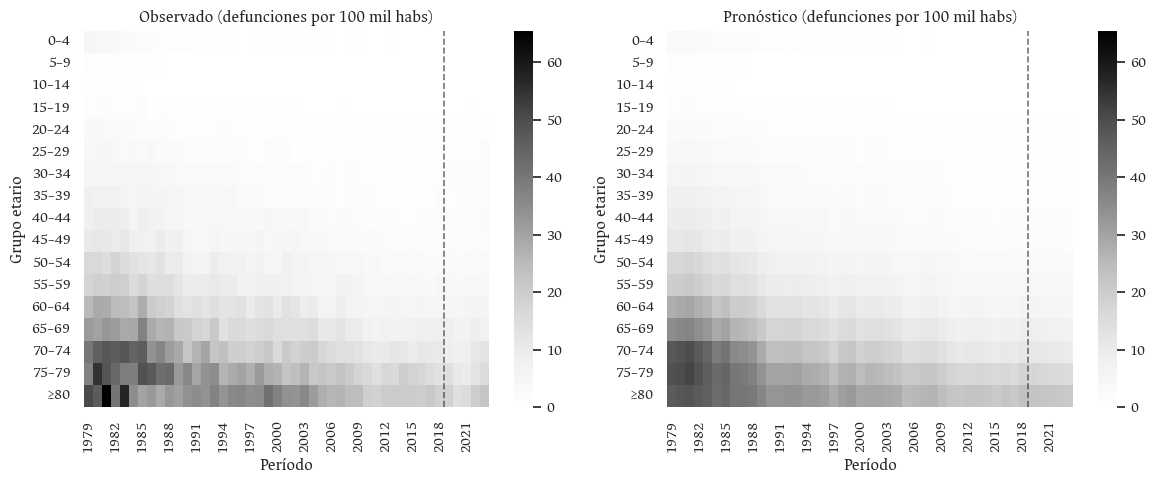

Guardada figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_heatmaps_obs_vs_forecast_correct.png


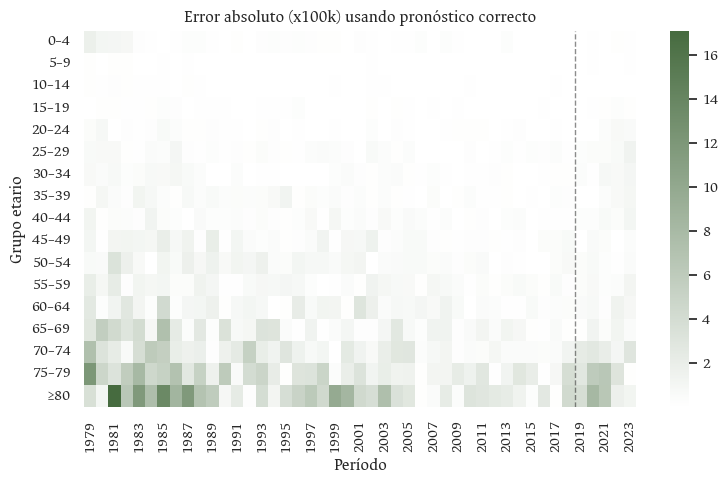

Guardada figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_heatmap_error_abs_forecast_correct.png


In [21]:
# Heatmaps observado vs pronóstico correcto (x100k) con split train/test
import numpy as n
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Verificaciones mínimas
req = ['m_hat_train','m_hat_test','years_train','years_test','ages','years','OUT_DIR','TRAIN_END_YEAR']
missing = [r for r in req if r not in globals()]
if missing:
    print("Faltan variables en el entorno para construir el pronóstico completo:", missing)
else:
    # Armar la matriz completa de pronóstico (todas las edades × todos los años)
    # Orden temporal: [years_train, years_test] que ya viene de las particiones de mat
    pred_full = np.concatenate([m_hat_train, m_hat_test], axis=1) if m_hat_test.size > 0 else m_hat_train
    # Asegurar consistencia de dimensiones
    assert pred_full.shape == (len(ages), len(years)), "Las dimensiones de pred_full no coinciden con (ages × years)."
    
    obs_100k = mat.values * 1e5
    pred_100k = pred_full * 1e5

    # Determinar una escala común (mismo colormap y mismos límites)
    vmin = 0.0
    vmax = float(np.nanmax([obs_100k.max(), pred_100k.max()]))
    # seq = get_sequential_cmap(0)  # mismo color para ambos
    seq = 'Greys'

    # Heatmaps lado a lado con misma escala
    fig, axes2 = plt.subplots(1,2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(obs_100k, index=ages, columns=years), ax=axes2[0], cmap=seq, vmin=vmin, vmax=vmax)
    axes2[0].set_title("Observado (defunciones por 100 mil habs)")
    axes2[0].set_xlabel("Período")
    axes2[0].set_ylabel("Grupo etario")
    axes2[0].set_yticklabels(get_age_labels(ages), rotation=0)
    axes2[0].spines['top'].set_visible(False)
    axes2[0].spines['right'].set_visible(False)

    sns.heatmap(pd.DataFrame(pred_100k, index=ages, columns=years), ax=axes2[1], cmap=seq, vmin=vmin, vmax=vmax)
    axes2[1].set_title("Pronóstico (defunciones por 100 mil habs)")
    axes2[1].set_xlabel("Período")
    axes2[1].set_ylabel("Grupo etario")
    axes2[1].set_yticklabels(get_age_labels(ages), rotation=0)
    axes2[1].spines['top'].set_visible(False)
    axes2[1].spines['right'].set_visible(False)

    # Línea vertical del corte train/test en ambos paneles
    try:
        years_int = np.asarray(years, dtype=int)
        cut_idx = int(np.where(years_int == int(TRAIN_END_YEAR))[0][0])
        x_cut = cut_idx + 1  # frontera entre la última columna de train y la primera de test
        for axh in axes2:
            axh.axvline(x=x_cut, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
            #axh.text(x_cut + 0.2, 0.5, f"Corte {int(TRAIN_END_YEAR)}", transform=axh.get_xaxis_transform(), rotation=90, va='center', ha='left', fontsize=8, color='k', alpha='0.7')
    except Exception as e:
        print("No se pudo dibujar la línea de corte:", e)

    plt.tight_layout()
    out_png = os.path.join(OUT_DIR, "lee_carter_heatmaps_obs_vs_forecast_correct.png")
    fig.savefig(out_png, dpi=150)
    plt.show()
    print("Guardada figura:", out_png)

    # Opcional: heatmap del error absoluto (x100k) para todo el período con el pronóstico correcto
    err_abs_100k = np.abs(obs_100k - pred_100k)
    fig2, ax2 = plt.subplots(figsize=(8,5))
    seq_err = get_sequential_cmap(2)
    sns.heatmap(pd.DataFrame(err_abs_100k, index=ages, columns=years), cmap=seq_err, ax=ax2)
    # Añadir también el corte para consistencia visual
    try:
        ax2.axvline(x=x_cut, color='k', linestyle='--', linewidth=1.0, alpha=0.5)
    except Exception:
        pass
    ax2.set_title("Error absoluto (x100k) usando pronóstico correcto")
    ax2.set_xlabel("Período")
    ax2.set_ylabel("Grupo etario")
    ax2.set_yticklabels(get_age_labels(ages), rotation=0)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.tight_layout()
    err_png = os.path.join(OUT_DIR, "lee_carter_heatmap_error_abs_forecast_correct.png")
    fig2.savefig(err_png, dpi=150)
    plt.show()
    print("Guardada figura:", err_png)

### Corrección: métricas por edad usando todas las edades

Recalculamos las métricas por edad directamente desde las matrices completas (`mat_train/m_hat_train` y `mat_test/m_hat_test`) para cubrir TODOS los grupos etarios y sobrescribimos los CSVs `*_by_age_{phase}.csv`.

In [15]:
# Recalcular métricas por edad desde matrices completas (train/test)
import numpy as np
import pandas as pd
import os

def _metrics_from_vectors(y_true_100k, y_pred_100k, eps):
    y_true_100k = np.asarray(y_true_100k, dtype=float)
    y_pred_100k = np.asarray(y_pred_100k, dtype=float)
    mae_x100k = float(np.mean(np.abs(y_true_100k - y_pred_100k)))
    mask = np.abs(y_true_100k) > (eps * 1e5)
    mape_x100k = float(np.mean(np.abs((y_true_100k[mask] - y_pred_100k[mask]) / y_true_100k[mask])) * 100.0) if mask.any() else float('nan')
    denom = np.abs(y_true_100k) + np.abs(y_pred_100k)
    sm = np.zeros_like(denom, dtype=float)
    m2 = denom > 0
    sm[m2] = 2.0 * np.abs(y_pred_100k[m2] - y_true_100k[m2]) / denom[m2]
    smape_x100k = float(100.0 * np.mean(sm))
    mse_x100k = float(np.mean((y_true_100k - y_pred_100k) ** 2))
    rmse_x100k = float(np.sqrt(mse_x100k))
    y_true_m = np.clip(y_true_100k / 1e5, EPS, None)
    y_pred_m = np.clip(y_pred_100k / 1e5, EPS, None)
    log_true = np.log(y_true_m)
    log_pred = np.log(y_pred_m)
    mse_logm = float(np.mean((log_true - log_pred) ** 2))
    rmse_logm = float(np.sqrt(mse_logm))
    return {
        'MAE_x100k': mae_x100k,
        'MAPE_%': mape_x100k,
        'SMAPE_%': smape_x100k,
        'MSE_x100k': mse_x100k,
        'RMSE_x100k': rmse_x100k,
        'MSE_logm': mse_logm,
        'RMSE_logm': rmse_logm,
    }

def _compute_by_age_from_mats(mat_df, mhat_arr, ages_vec, eps):
    rows = []
    for i, a in enumerate(ages_vec):
        y_true_100k = mat_df.iloc[i, :].to_numpy(dtype=float) * 1e5
        y_pred_100k = mhat_arr[i, :] * 1e5
        met = _metrics_from_vectors(y_true_100k, y_pred_100k, eps)
        row = {'age': int(a), 'N': int(y_true_100k.size), 'age_label': age_label(int(a))}
        row.update(met)
        rows.append(row)
    return pd.DataFrame(rows)

# Validaciones mínimas
req = ['mat_train','mat_test','m_hat_train','m_hat_test','ages','OUT_DIR']
missing = [r for r in req if r not in globals()]
if missing:
    print("Faltan variables requeridas:", missing)
else:
    # Train
    df_age_train_full = _compute_by_age_from_mats(mat_train, m_hat_train, ages, EPS)
    out_age_tr = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_train.csv')
    df_age_train_full.to_csv(out_age_tr, index=False)
    print("Recalculado y guardado (por edad - train):", out_age_tr)
    display(df_age_train_full.head())
    
    # Test (si existe)
    if m_hat_test.size > 0 and mat_test.shape[1] > 0:
        df_age_test_full = _compute_by_age_from_mats(mat_test, m_hat_test, ages, EPS)
        out_age_ts = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_test.csv')
        df_age_test_full.to_csv(out_age_ts, index=False)
        print("Recalculado y guardado (por edad - test):", out_age_ts)
        display(df_age_test_full.head())
    else:
        print("No hay período de prueba (h=0): se omite el cálculo por edad para test.")

Recalculado y guardado (por edad - train): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_by_age_train.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,40,0–4,0.246323,20.977973,20.656620,0.186141,0.431441,0.070855,0.266186
1,2,40,5–9,0.036569,10.116411,10.075534,0.003386,0.058185,0.015768,0.125570
2,3,40,10–14,0.061621,27.336048,25.577591,0.006473,0.080455,0.104968,0.323988
3,4,40,15–19,0.085507,12.388286,12.259679,0.012611,0.112299,0.024476,0.156446
4,5,40,20–24,0.150963,10.471745,10.454695,0.048822,0.220957,0.017662,0.132900


Recalculado y guardado (por edad - test): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_metrics_by_age_test.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,5,0–4,0.096895,31.294273,32.448766,0.012084,0.109926,0.132983,0.364668
1,2,5,5–9,0.045418,47.724736,59.225106,0.003730,0.061075,0.616494,0.785171
2,3,5,10–14,0.051333,41.177425,52.504484,0.002855,0.053436,0.308281,0.555230
3,4,5,15–19,0.148521,30.647378,37.893131,0.029331,0.171264,0.192123,0.438318
4,5,5,20–24,0.326301,28.754909,37.280049,0.177470,0.421271,0.240918,0.490834


## Paneles de métricas por edad y por período (train vs test)

Construimos dos figuras (12×8):
- Panel por edad (x = grupos etarios), comparando train vs test para 6 métricas.
- Panel por período (x = años), comparando train vs test para las mismas métricas.

Se guardan PNGs en `OUT_DIR`.

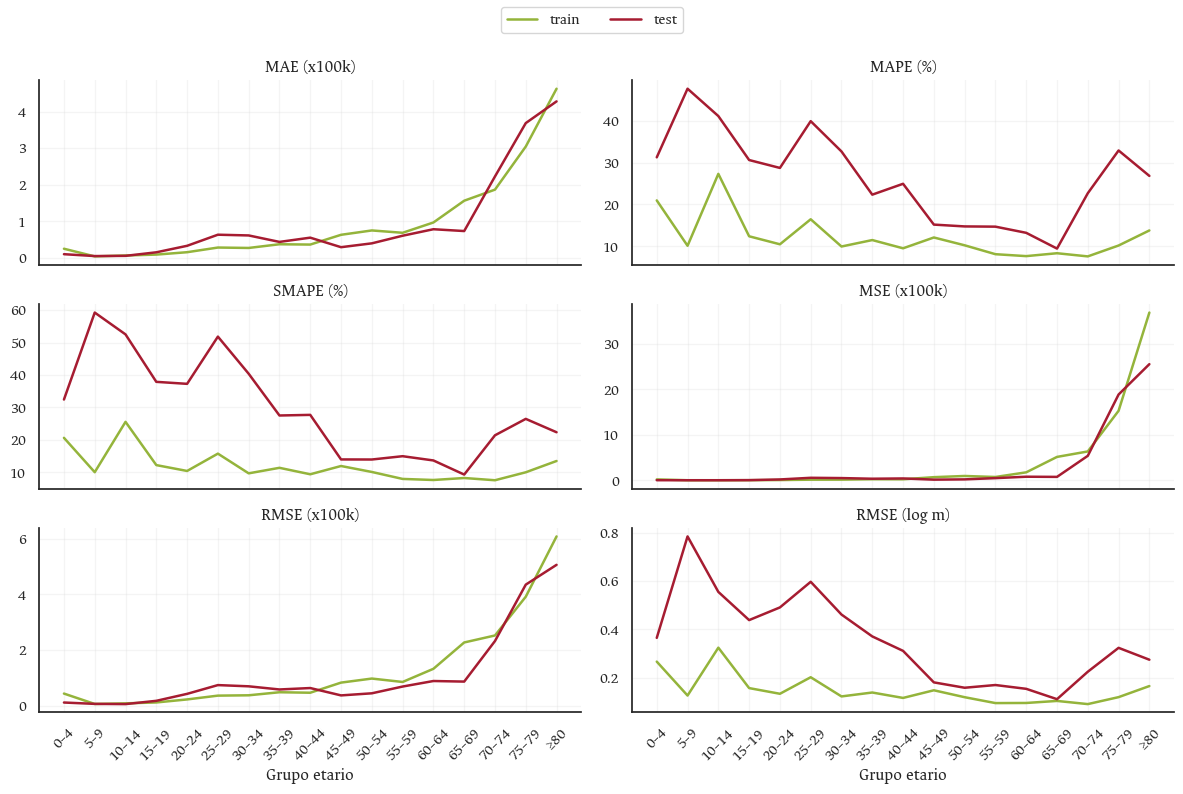

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_metrics_panels_by_age.png


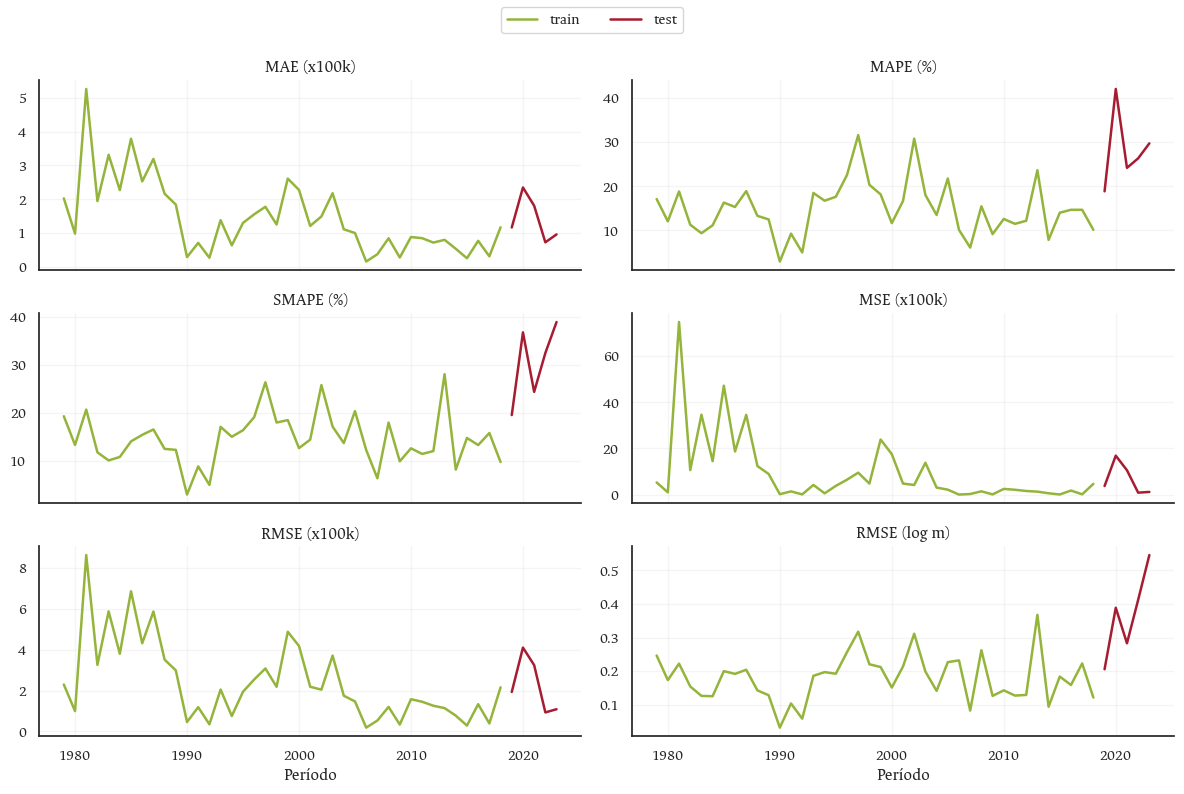

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_metrics_panels_by_year.png


In [16]:
# Figuras de paneles de métricas (por edad y por año)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

palette2 = get_palette(2)  # [train, test]

def _plot_panels(df_tr, df_ts, xcol, xlabel, out_png):
    metrics = [
        ('MAE_x100k', 'MAE (x100k)'),
        ('MAPE_%', 'MAPE (%)'),
        ('SMAPE_%', 'SMAPE (%)'),
        ('MSE_x100k', 'MSE (x100k)'),
        ('RMSE_x100k', 'RMSE (x100k)'),
        ('RMSE_logm', 'RMSE (log m)'),
    ]
    # Compartir eje X por columna
    fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex='col')
    axes = axes.reshape(3, 2)

    # Precalcular valores X para etiquetas cuando xcol es 'age'
    unique_x = None
    if xcol == 'age':
        if df_ts is not None and not df_ts.empty:
            unique_x = sorted(set(df_tr[xcol].tolist()) | set(df_ts[xcol].tolist()))
        else:
            unique_x = sorted(df_tr[xcol].unique().tolist())

    for i, (met, title) in enumerate(metrics):
        r, c = divmod(i, 2)
        ax = axes[r, c]
        ax.plot(df_tr[xcol], df_tr[met], label='train', color=palette2[0], linewidth=1.8)
        if df_ts is not None and not df_ts.empty:
            ax.plot(df_ts[xcol], df_ts[met], label='test', color=palette2[1], linewidth=1.8)
        ax.set_title(title)
        ax.grid(alpha=0.2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Ocultar etiquetas de X en filas superiores; solo la fila inferior las muestra
        if r < 2:
            ax.tick_params(labelbottom=False)
        else:
            ax.set_xlabel(xlabel)

    # Etiquetas de grupo etario en eje X si corresponde (ponerlas en la fila inferior; se comparten por columna)
    if xcol == 'age' and unique_x is not None:
        for c in range(2):
            set_age_ticks(axes[2, c], unique_x, 'x')

    # Leyenda común
    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(out_png, dpi=150)
    plt.show()
    print("Guardado:", out_png)

# Panel por edad
age_tr_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_train.csv')
age_ts_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_test.csv')
if os.path.exists(age_tr_csv):
    df_age_tr = pd.read_csv(age_tr_csv).sort_values('age')
    if os.path.exists(age_ts_csv):
        df_age_ts = pd.read_csv(age_ts_csv).sort_values('age')
    else:
        df_age_ts = pd.DataFrame(columns=df_age_tr.columns)
    out_age_png = os.path.join(OUT_DIR, 'lee_carter_metrics_panels_by_age.png')
    _plot_panels(df_age_tr, df_age_ts, xcol='age', xlabel='Grupo etario', out_png=out_age_png)
else:
    print("No se encontró el CSV por edad. Ejecuta antes el cálculo de métricas.")

# Panel por año
year_tr_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_year_train.csv')
year_ts_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_year_test.csv')
if os.path.exists(year_tr_csv):
    df_year_tr = pd.read_csv(year_tr_csv).sort_values('year')
    if os.path.exists(year_ts_csv):
        df_year_ts = pd.read_csv(year_ts_csv).sort_values('year')
    else:
        df_year_ts = pd.DataFrame(columns=df_year_tr.columns)
    out_year_png = os.path.join(OUT_DIR, 'lee_carter_metrics_panels_by_year.png')
    _plot_panels(df_year_tr, df_year_ts, xcol='year', xlabel='Período', out_png=out_year_png)
else:
    print("No se encontró el CSV por año. Ejecuta antes el cálculo de métricas.")

# Guardado

In [17]:
# Guardado de información — Matriz Lexis (pred_x100k) para TODAS las edades y todos los períodos (train+test)
import os
import numpy as np
import pandas as pd

# Requeridos desde las secciones previas (no modificadas):
req = ['m_hat_train','m_hat_test','years_train','years_test','ages','OUT_DIR']
missing = [r for r in req if r not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables en el entorno: {missing}. Ejecuta las celdas anteriores.")

# Ensamblar predicciones completas (edades × años)
pred_full = np.concatenate([m_hat_train, m_hat_test], axis=1) if m_hat_test.size > 0 else m_hat_train
years_full = np.concatenate([years_train, years_test]) if m_hat_test.size > 0 else years_train

# A tasas por 100 mil
pred_100k = pred_full * 1e5

# DataFrame estilo Lexis: filas = gr_et (edad), columnas = años
mat_lexis = pd.DataFrame(pred_100k, index=ages, columns=years_full)
mat_lexis.index.name = 'gr_et'
mat_lexis = mat_lexis.sort_index(axis=0).sort_index(axis=1)

os.makedirs(OUT_DIR, exist_ok=True)
lexis_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_lexis_x100k.csv')
mat_lexis.to_csv(lexis_csv)
print("Guardado (Lexis pred_x100k, todas las edades y períodos):", lexis_csv)
print("Forma:", mat_lexis.shape, "\nEdades:", len(mat_lexis.index), "Años:", len(mat_lexis.columns))

Guardado (Lexis pred_x100k, todas las edades y períodos): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_lexis_x100k.csv
Forma: (17, 45) 
Edades: 17 Años: 45


In [18]:
# Guardado de información — Tabla larga (observado + predicho) para TODAS las edades y períodos (train+test)
import os
import numpy as np
import pandas as pd

req = ['mat_train','mat_test','m_hat_train','m_hat_test','years_train','years_test','ages','OUT_DIR','TRAIN_END_YEAR']
missing = [r for r in req if r not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables en el entorno: {missing}. Ejecuta las celdas anteriores.")

rows = []
ages_list = [int(a) for a in np.array(ages).tolist()]

# Construir filas de train y test directamente desde las matrices completas
for i, a in enumerate(ages_list):
    # Observados y predichos en train
    obs_tr = mat_train.loc[a, :].to_numpy(dtype=float) * 1e5
    pred_tr = m_hat_train[i, :] * 1e5
    df_tr = pd.DataFrame({
        'age': a,
        'age_label': etiquetas_gr.get(int(a), str(a)) if 'etiquetas_gr' in globals() else str(a),
        'year': years_train,
        'obs_x100k': obs_tr,
        'pred_x100k': pred_tr,
        'phase': 'train'
    })
    rows.append(df_tr)

    # Observados y predichos en test (si hay)
    if m_hat_test.size > 0 and mat_test.shape[1] > 0:
        obs_ts = mat_test.loc[a, :].to_numpy(dtype=float) * 1e5
        pred_ts = m_hat_test[i, :] * 1e5
        df_ts = pd.DataFrame({
            'age': a,
            'age_label': etiquetas_gr.get(int(a), str(a)) if 'etiquetas_gr' in globals() else str(a),
            'year': years_test,
            'obs_x100k': obs_ts,
            'pred_x100k': pred_ts,
            'phase': 'test'
        })
        rows.append(df_ts)

combined_df = pd.concat(rows, ignore_index=True)
combined_df = combined_df.sort_values(['age', 'year']).reset_index(drop=True)

# Errores (con guardas por división entre cero)
combined_df['err_abs'] = np.abs(combined_df['obs_x100k'] - combined_df['pred_x100k'])
combined_df['error_pct'] = np.where(
    combined_df['obs_x100k'] > 0,
    combined_df['err_abs'] / combined_df['obs_x100k'] * 100.0,
    np.nan
)

# Guardar CSV largo definitivo (sobrescribe)
os.makedirs(OUT_DIR, exist_ok=True)
forecast_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_by_age.csv')
combined_df.to_csv(forecast_csv, index=False)
print("Guardado (largo, todas las edades y períodos):", forecast_csv)
print("Nº edades:", combined_df['age'].nunique(), "Nº años:", combined_df['year'].nunique())
print("Rango de años:", int(combined_df['year'].min()), "-", int(combined_df['year'].max()))

Guardado (largo, todas las edades y períodos): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_by_age.csv
Nº edades: 17 Nº años: 45
Rango de años: 1979 - 2023


In [19]:
# Clasificación 30% sobre/subestimación desde `combined_df`
if 'combined_df' not in globals():
    raise RuntimeError("No se encontró 'combined_df' en el entorno. Ejecuta la celda que construye el dataframe largo (lee_carter_forecast_by_age).")

df = combined_df.copy()

# Asegurar valores numéricos
df['obs_x100k'] = pd.to_numeric(df['obs_x100k'], errors='coerce')
df['pred_x100k'] = pd.to_numeric(df['pred_x100k'], errors='coerce')

def _clasificar_30pct(obs, pred, tol=0.30):
    if pd.isna(obs) or pd.isna(pred):
        return 'missing'
    if obs == 0:
        return 'sobreestimada' if pred > 0 else 'en rango'
    ratio = pred / obs
    if ratio > 1.0 + tol:
        return 'sobreestimada'
    if ratio < 1.0 - tol:
        return 'subestimada'
    return 'en rango'

df['clasif_30pct'] = df.apply(lambda r: _clasificar_30pct(r['obs_x100k'], r['pred_x100k']), axis=1)

# Resumen: conteos y porcentajes
summary = (
    df['clasif_30pct']
      .value_counts(dropna=False)
      .rename_axis('clasificacion')
      .reset_index(name='count')
)
summary['pct'] = (summary['count'] / len(df)) * 100.0

# Guardar resultados
os.makedirs(OUT_DIR, exist_ok=True)
out_classified = os.path.join(OUT_DIR, 'lee_carter_forecast_by_age_classified_30pct.csv')
out_summary = os.path.join(OUT_DIR, 'lee_carter_forecast_by_age_classified_summary_30pct.csv')
df.to_csv(out_classified, index=False)
summary.to_csv(out_summary, index=False)

print("Guardado (filas clasificadas):", out_classified)
print("Guardado (resumen):", out_summary)
print("\nResumen de clasificación (porcentaje sobre el total):")
display(summary)

# Mostrar primeras filas con la nueva clasificación
df.head()

Guardado (filas clasificadas): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_by_age_classified_30pct.csv
Guardado (resumen): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_02_lee_carter_rank2/lee_carter_forecast_by_age_classified_summary_30pct.csv

Resumen de clasificación (porcentaje sobre el total):


,clasificacion,count,pct
0,en rango,692,90.457516
1,sobreestimada,39,5.098039
2,subestimada,34,4.444444


,age,age_label,year,obs_x100k,pred_x100k,phase,err_abs,error_pct,clasif_30pct
0,1,0–4,1979,4.902391,3.118452,train,1.783939,36.389163,subestimada
1,1,0–4,1980,4.247333,3.136340,train,1.110992,26.157413,en rango
2,1,0–4,1981,4.420562,3.388362,train,1.032200,23.349971,en rango
3,1,0–4,1982,3.948397,3.026352,train,0.922045,23.352379,en rango
4,1,0–4,1983,2.787878,2.584887,train,0.202991,7.281199,en rango
